<a href="https://colab.research.google.com/github/krish146/-skin-cancer-investigator/blob/main/Copy_of_Skin_canser_84_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
fanconic_skin_cancer_malignant_vs_benign_path = kagglehub.dataset_download('fanconic/skin-cancer-malignant-vs-benign')
print(fanconic_skin_cancer_malignant_vs_benign_path)
print('Data source import complete.')


100%|██████████| 325M/325M [00:02<00:00, 129MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4
Data source import complete.


In [7]:
#import libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import keras
from keras.applications import VGG19,Xception,VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.applications.resnet50 import ResNet50
from keras import layers
import tensorflow as tf


In [10]:
import os

# Define the path to the 'data' folder
data_folder_path = '/root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/data'

# List the contents of the 'data' folder
print(os.listdir(data_folder_path))


['test', 'train']


In [9]:
import os
import cv2
import numpy as np
from skimage.io import imread, imsave
from multiprocessing import Pool

# Path to the original dataset
input_dir = '/root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/data'
output_dir = '/root/.cache/kagglehub/datasets/fanconic/segmented_data'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Segmentation function using thresholding
def segment_skin_lesion(image):
    """
    Perform simple threshold-based segmentation to separate the skin lesion from the background.
    This method assumes the lesion has a different intensity or color compared to the background.
    """
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply a simple threshold to segment the lesion area
    _, thresholded = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

    # Optionally, you can use morphological operations to clean up the image
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

    # Create a mask for the lesion and apply it to the original image
    mask = cleaned.astype(np.uint8)
    segmented_image = cv2.bitwise_and(image, image, mask=mask)

    return segmented_image

# Helper function to process and save an image
def process_and_save_image(args):
    """
    Function for processing and saving a single image.
    Used for parallel processing.
    """
    image_path, output_path = args
    image = imread(image_path)
    segmented_image = segment_skin_lesion(image)
    imsave(output_path, segmented_image)

# Function to process and save segmented images in parallel
def segment_and_save_parallel(input_dir, output_dir):
    tasks = []

    for folder in ['train', 'test']:
        input_folder = os.path.join(input_dir, folder)
        output_folder = os.path.join(output_dir, folder)
        os.makedirs(output_folder, exist_ok=True)

        for class_name in os.listdir(input_folder):
            class_input_folder = os.path.join(input_folder, class_name)
            class_output_folder = os.path.join(output_folder, class_name)
            os.makedirs(class_output_folder, exist_ok=True)

            for image_name in os.listdir(class_input_folder):
                image_path = os.path.join(class_input_folder, image_name)
                output_path = os.path.join(class_output_folder, image_name)
                tasks.append((image_path, output_path))

    # Process images in parallel
    with Pool(processes=4) as pool:  # Adjust the number of processes as per your CPU
        pool.map(process_and_save_image, tasks)

# Apply segmentation and save the images
segment_and_save_parallel(input_dir, output_dir)


<ipython-input-9-37a554dea91c>:45: UserWarning: /root/.cache/kagglehub/datasets/fanconic/segmented_data/train/malignant/571.jpg is a low contrast image
  imsave(output_path, segmented_image)
<ipython-input-9-37a554dea91c>:45: UserWarning: /root/.cache/kagglehub/datasets/fanconic/segmented_data/train/malignant/729.jpg is a low contrast image
  imsave(output_path, segmented_image)
<ipython-input-9-37a554dea91c>:45: UserWarning: /root/.cache/kagglehub/datasets/fanconic/segmented_data/train/malignant/540.jpg is a low contrast image
  imsave(output_path, segmented_image)
<ipython-input-9-37a554dea91c>:45: UserWarning: /root/.cache/kagglehub/datasets/fanconic/segmented_data/test/malignant/528.jpg is a low contrast image
  imsave(output_path, segmented_image)


In [10]:
# Train data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    rotation_range=40,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True
)

train_data = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(64, 64),
    class_mode='sparse',
    shuffle=True,
    seed=1
)

# Test data generator without augmentation
test_datagen = ImageDataGenerator(rescale=1/255)

test_data = test_datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(64, 64),
    class_mode='sparse',
    shuffle=True,
    seed=1
)


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [4]:
#display classes names
class_names = ["Benign","Malignant"]
for i in class_names :
    print(class_names.index(i),"  ",i)

0    Benign
1    Malignant


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


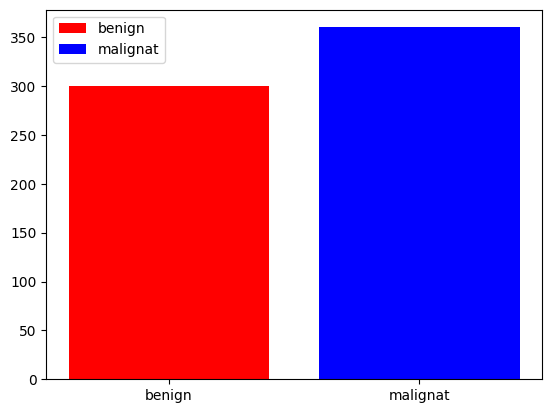

In [11]:
#visulaize test_data
fig, ax = plt.subplots()
ax.bar(["benign"],[300],color= "r",label='benign')
ax.bar(["malignat"],[360],color ="b",label ="malignat")
ax.legend()

benign


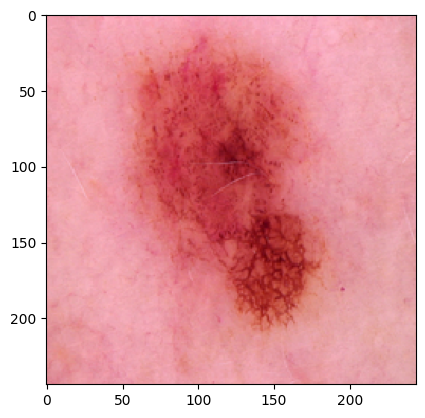

In [15]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Update image path to point to the correct location
image_path = "/root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/data/test/benign/1261.jpg"

# Load and preprocess the image
new_img = image.load_img(image_path, target_size=(244, 244))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)

# Print class label (benign)
print("benign")

# Display the image
plt.imshow(new_img)
plt.show()


malignant


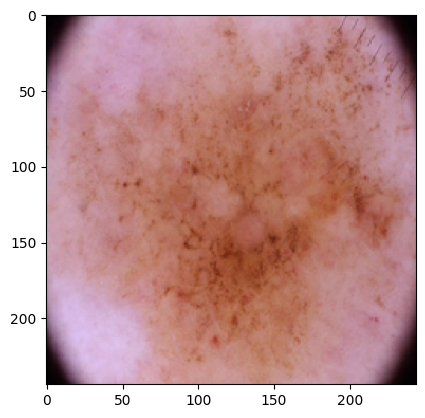

In [6]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Update image path to point to the correct location
image_path = "/root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/data/test/malignant/1080.jpg"

# Load and preprocess the image
new_img = image.load_img(image_path, target_size=(244, 244))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)

# Print class label (malignant)
print("malignant")

# Display the image
plt.imshow(new_img)
plt.show()


In [12]:
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2, activation='softmax')
])


In [13]:
#compile the model
import tensorflow as tf
model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

#early stopping function
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [14]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50
)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 325ms/step - accuracy: 0.5701 - loss: 0.9075 - val_accuracy: 0.6439 - val_loss: 0.5962
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 37s 279ms/step - accuracy: 0.7196 - loss: 0.5317 - val_accuracy: 0.7818 - val_loss: 0.4337
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 274ms/step - accuracy: 0.7666 - loss: 0.4622 - val_accuracy: 0.7864 - val_loss: 0.4251
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 312ms/step - accuracy: 0.7503 - loss: 0.4789 - val_accuracy: 0.7818 - val_loss: 0.4100
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 344ms/step - accuracy: 0.7730 - loss: 0.4599 - val_accuracy: 0.8061 - val_loss: 0.3954
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 27s 320ms/step - accuracy: 0.7902 - loss: 0.4477 - val_accuracy: 0.8045 - val_loss: 0.3979
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - accuracy: 0.7914 - loss: 0.4311 - val_accuracy: 0.7985 - val_loss: 0.4167
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 307ms/step - accuracy: 0.8089 - loss: 0.4289 - val_accuracy: 0.810

In [22]:
#evulate model
model.evaluate(test_data)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8322 - loss: 0.3944


[0.37355470657348633, 0.8363636136054993]

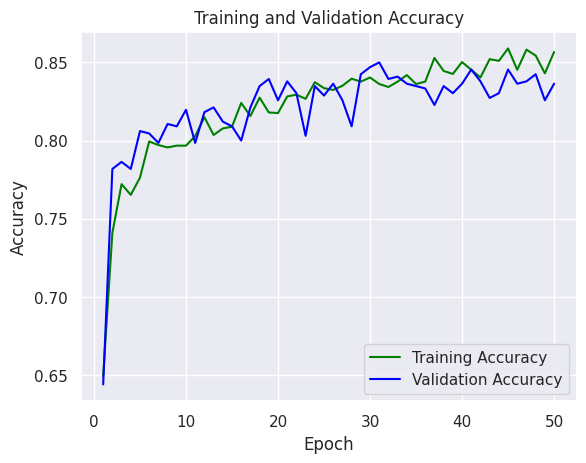

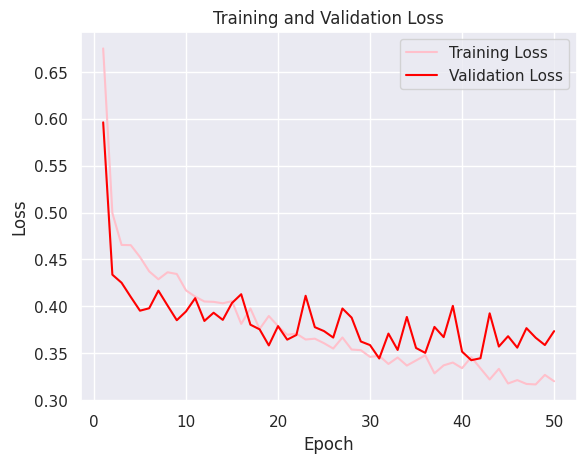

In [16]:
# Plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
# Loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [17]:
#predict val data
y_pred = model.predict(test_data)
y_pred =  np.argmax(y_pred,axis=1)

print(y_pred)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
[1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1
 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0
 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0
 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1
 0 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0
 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0
 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0
 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1
 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0
 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 1
 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1
 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
[0]
Benign


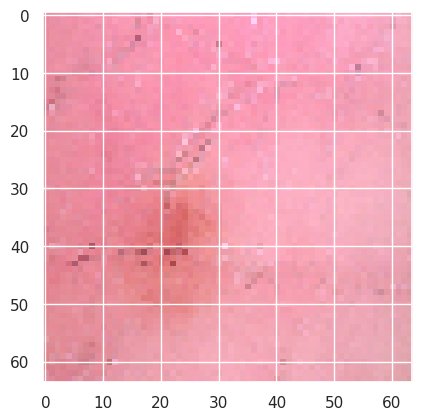

In [18]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

image_path = "/root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/data/test/benign/1006.jpg"  # Change this path accordingly
new_img = image.load_img(image_path, target_size=(64, 64))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
prediction = np.argmax(prediction, axis=1)
print(prediction)
print(class_names[prediction[0]])
plt.imshow(new_img)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[1]
Malignant


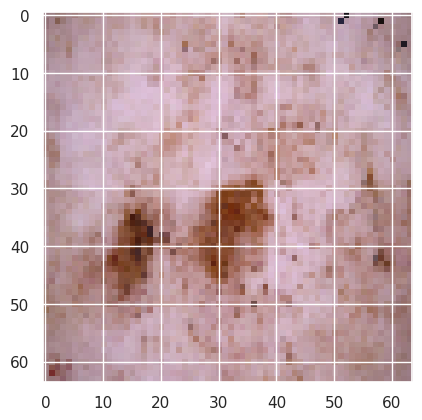

In [19]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

image_path = "/root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/data/train/malignant/1006.jpg"  # Change this path accordingly
new_img = image.load_img(image_path, target_size=(64, 64))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
prediction = np.argmax(prediction, axis=1)
print(prediction)
print(class_names[prediction[0]])
plt.imshow(new_img)
plt.show()


In [ ]:
#example 3
from keras.preprocessing import image
import numpy as np
image_path = "../input/skin-cancer-malignant-vs-benign/test/benign/1261.jpg"
new_img = image.load_img(image_path, target_size=(64, 64))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
prediction = np.argmax(prediction,axis=1)
print(prediction)
print(class_names[prediction[0]])
plt.imshow(new_img)


In [ ]:
#example 3=4
from keras.preprocessing import image
import numpy as np
image_path = "../input/skin-cancer-malignant-vs-benign/test/malignant/1058.jpg"
new_img = image.load_img(image_path, target_size=(64, 64))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
prediction = np.argmax(prediction,axis=1)
print(prediction)
print(class_names[prediction[0]])
plt.imshow(new_img)


In [20]:
#save file as h5 model
from keras.models import model_from_json
xception_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(xception_json)
# serialize weights to HDF5
model.save("model_skin2.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model_skin.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmp69x3mtv7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  134450011015472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134450011013712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134450010680384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134450010678976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134450661194416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134450011028496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134450011026912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449975709888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134450010676688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449975718512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449975714816: